In [57]:
# Instala la biblioteca pyproj si no está instalada
!pip install pyproj

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [58]:
# Importación de las librerías necesarias
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime
import pyproj

In [59]:
# URL del archivo de datos
ruta = 'https://raw.githubusercontent.com/fmoreno4/datasets/main/eventos_dengue_2020.csv'

# Lectura del archivo CSV en un DataFrame
df = pd.read_csv(ruta)
df

,ID,fec_not,semana,año,edad_,uni_med_,sexo_,cod_pais_o,cod_dpto_o,cod_mun_o,...,hipotension,hepatomegalia,hemorragia_mucosa,hipotermia,caida_plaquetas,acum_liquido,aum_hematocrito,conducta,latitud,longitud
0,1,17/01/2020,1,2020,25,1,F,170,68,276,...,2,2,2,2,2,2,2,1. Ambulatorio,7.076011,-73.102501
1,2,10/01/2020,1,2020,24,1,M,170,68,276,...,2,2,2,2,2,2,2,1. Ambulatorio,7.079495,-73.105400
2,3,12/01/2020,1,2020,58,1,M,170,68,276,...,2,2,2,2,2,2,2,1. Ambulatorio,7.090290,-73.091003
3,4,12/01/2020,1,2020,29,1,F,170,68,276,...,2,2,2,2,2,2,2,1. Ambulatorio,7.067435,-73.090958
4,5,10/01/2020,1,2020,56,1,F,170,68,276,...,2,2,2,2,1,2,2,2. Hospitalizacion piso,7.066905,-73.104980
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1257,1258,7/03/2020,9,2020,36,1,F,170,68,276,...,2,2,1,2,2,2,2,1. Ambulatorio,7.072610,-73.099487
1258,1259,13/03/2020,9,2020,42,1,M,170,68,276,...,2,2,2,2,1,2,1,2. Hospitalizacion piso,7.065252,-73.103607
1259,1260,8/03/2020,9,2020,2,1,M,170,68,276,...,2,2,2,2,2,2,2,1. Ambulatorio,7.091391,-73.103264
1260,1261,11/03/2020,9,2020,12,1,F,170,68,276,...,2,2,2,2,2,2,2,1. Ambulatorio,7.061083,-73.097000


In [60]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1262 entries, 0 to 1261
Data columns (total 51 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   ID                 1262 non-null   int64  
 1   fec_not            1262 non-null   object 
 2   semana             1262 non-null   int64  
 3   año                1262 non-null   int64  
 4   edad_              1262 non-null   int64  
 5   uni_med_           1262 non-null   int64  
 6   sexo_              1262 non-null   object 
 7   cod_pais_o         1262 non-null   int64  
 8   cod_dpto_o         1262 non-null   int64  
 9   cod_mun_o          1262 non-null   int64  
 10  area_              1262 non-null   int64  
 11  ocupacion_         1262 non-null   int64  
 12  tip_ss_            1262 non-null   object 
 13  cod_ase_           1253 non-null   object 
 14  gp_discapa         1262 non-null   int64  
 15  gp_desplaz         1262 non-null   int64  
 16  gp_migrant         1262 

In [61]:
# Formatea las columnas de fecha en el DataFrame
df['fec_not2'] = pd.to_datetime(df['fec_not'], format="%d/%m/%Y")
df['fecha_contagio2'] = pd.to_datetime(df['fecha_contagio'], format="%d/%m/%Y")
df['inicio_sintomas2'] = pd.to_datetime(df['inicio_sintomas'], format="%d/%m/%Y")
df['fec_hos_2'] = pd.to_datetime(df['fec_hos_'], format="%d/%m/%Y")

In [62]:
# Creación de la proyección UTM
P = pyproj.Proj(proj='utm', zone=18, ellps='WGS84', preserve_units=True)

In [63]:
# Conversión de coordenadas geográficas a UTM
df['x'], df['y'] = P(df['longitud'], df['latitud'])

In [64]:
# Tamaño del cuadro de la matriz y ancho de banda para el kernel
res = 10
bw = 200
kernel_bandwidth = 4

In [65]:
# Función para calcular el kernel
def kernel(distancia, bw):
    if distancia > bw:
        return 0
    u = distancia / bw
    return (3/4) * (1 - u**2)

In [66]:
# Cálculo de los límites del área de estudio
xMin = df['x'].min() - bw
xMax = df['x'].max() + bw
yMin = df['y'].min() - bw
yMax = df['y'].max() + bw

import math

In [67]:
# Cálculo del número de filas y columnas de la matriz
numFilas = math.ceil((yMax - yMin) / res)
numCols = math.ceil((xMax - xMin) / res)

In [68]:
# Creación de una lista de listas vacías para la cuadrícula
grid = [[[] for j in range(numCols)] for i in range(numFilas)]

In [69]:
# Agregando puntos a la cuadrícula
for i, row in df.iterrows():
    x, y = row['x'], row['y']
    row_idx = int((y - yMin) / res)
    col_idx = int((x - xMin) / res)
    grid[row_idx][col_idx].append((x, y))

In [70]:
# Creación de una matriz para almacenar el recuento de casos en cada cuadro de la cuadrícula
grid_count = np.zeros((numFilas, numCols))

In [71]:
# Cálculo del recuento de casos en cada cuadro de la cuadrícula
for i in range(numFilas):
    for j in range(numCols):
        grid_count[i][j] = len(grid[i][j])

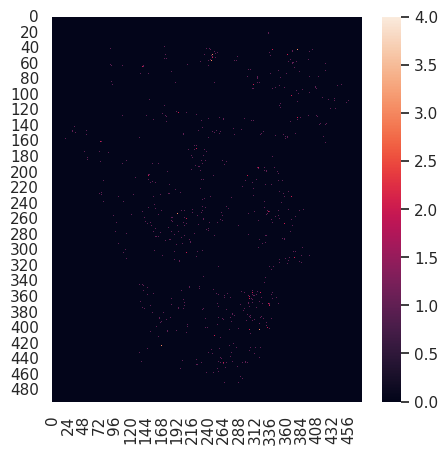

In [72]:
# Visualización del mapa de calor del recuento de casos
sns.set(rc={'figure.figsize': (5, 5)})
p = sns.heatmap(grid_count)

In [79]:
import numpy as np
from scipy.spatial.distance import cdist
from scipy.ndimage.filters import gaussian_filter
import matplotlib.pyplot as plt

<ipython-input-79-8cd30812f42f>:3: DeprecationWarning: Please use `gaussian_filter` from the `scipy.ndimage` namespace, the `scipy.ndimage.filters` namespace is deprecated.
  from scipy.ndimage.filters import gaussian_filter


In [80]:
# Definir las funciones de kernel
def kernel_epanechnikov(x):
    x = np.abs(x)
    return np.where(x <= 200, (3/4) * (1 - (x/200)**2), 0)

def kernel_uniform(x):
    if abs(x) <= 1:
        return 0.5
    else:
        return 0

def kernel_triangular(x):
    if abs(x) <= 1:
        return 1 - abs(x)
    else:
        return 0

def kernel_laplace(x):
    return (1/2) * np.exp(-abs(x))

In [83]:
# Crear la matriz de densidades
density_grid = np.zeros((numFilas, numCols))

for i in range(numFilas):
    for j in range(numCols):
        num_points = len(grid[i][j])  # Número de puntos en la celda
        if num_points > 0:
            distances = cdist([(i, j)], [(i, j)])[0]  # Distancia a sí misma (0)
            kernel_values = kernel_epanechnikov(distances)  # Utilizar el kernel Epanechnikov
            density = np.sum(kernel_values) / num_points
            density_grid[i][j] = density

In [84]:
# Definir la desviación estándar del kernel gaussiano
sigma = 20

In [85]:
# Suavizar la matriz de densidad con una convolución gaussiana
density_smooth = gaussian_filter(density_grid, sigma=sigma)

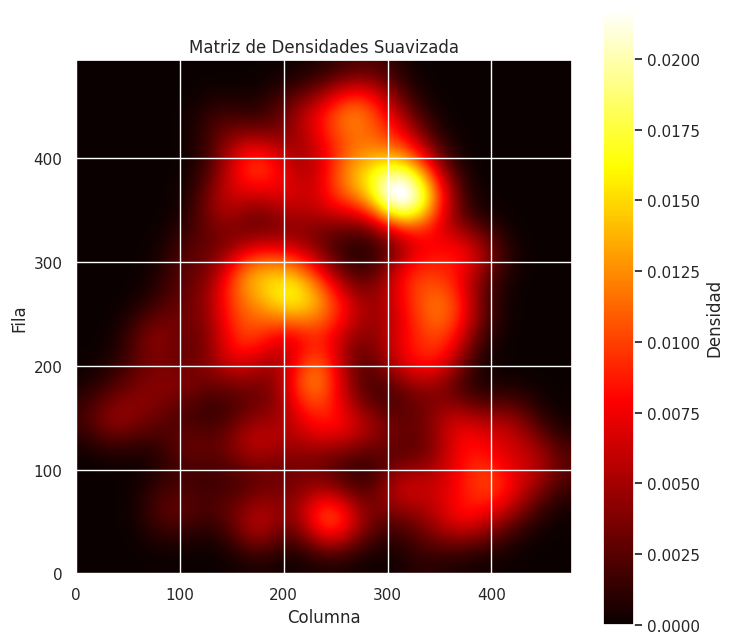

In [86]:
# Graficar la matriz de densidades suavizada
plt.imshow(density_smooth, cmap='hot', origin='lower')
plt.colorbar(label='Densidad')
plt.xlabel('Columna')
plt.ylabel('Fila')
plt.title('Matriz de Densidades Suavizada')
plt.show()